# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 07.06.2024**

**Мягкий дедлайн: 24.06.2024 23:59 MSK**

**Жёсткий дедлайн: 24.06.2024 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

import matplotlib.pyplot as plt
import time

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    """
    вычисляет среднюю точность на k (MAP@k) для набора релевантных и предсказанных элементов
    """

    def apuk(relevant: List[int], predicted: List[int], k: int) -> float:
        """
        вычисляет точность на k (AP@k) для одного набора релевантных и предсказанных элементов.
        """

        # ограничиваем количество предсказанных элементов k первыми элементами
        if k < len(predicted):
            predicted = predicted[:k]
        
        # преобразуем релевантные элементы в множество для быстрого поиска
        relevant = set(relevant)
        total = 0.0
        num_hits = 0
        
        # проходим по всем предсказанным элементам
        for i in range(len(predicted)):
            if predicted[i] in relevant:
                num_hits += 1
                total += float(num_hits) / float(i + 1)          # вычисляем точность на текущем шаге
        
        # если нет релевантных элементов, возвращаем 0.0
        if not relevant:
            return 0.0
        
        total /= float(min(len(relevant), k))        # вычисляем среднюю точность с учетом минимального значения между количеством релевантных элементов и k
        return total
    
    return np.mean([apuk(relevant[i], predicted[i], k) for i in range(len(predicted))])        # вычисляем среднюю точность для всех примеров и возвращаем результат

In [ ]:
# примеры релевантных и предсказанных элементов для проверки функции

relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331        # проверяем правильность работы функции с примерами

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # получаем образцы из train
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # получаем образцы из test
    # отбрасываем все треки, которые не представлены в обучающих образцах (не сможем выучить представления для них)
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
# находим и удаляем строки, содержащие треки, отсутствующие в обучающей выборке
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # создаем кодировщики для пользователей и треков
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # обучаем кодировщики на идентификаторах пользователей и треков
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings) # создаем и обучаем кодировщики
# кодируем идентификаторы треков в обучающей и тестовой выборках
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())

tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())         # кодируем идентификаторы треков в информации о треках

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
# подготавливаем релевантные треки для тестовой выборки
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        # инициализация модели, создание матрицы пользователь-элемент
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        # создание матрицы рейтингов
        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]        # удаляем уже прослушанные треки из рекомендованных

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        test_preds = [self.recommend(i) for i in range(self.n_users)]        # получаем рекомендации для всех пользователей
        try:
            test_preds = self.remove_train_items(test_preds, k)
        except:
            pass
        return test_preds[test_users]        # возвращаем рекомендации только для тестовых пользователей

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    both = ratings @ user_vector.T        # количество треков, которые оба пользователя (заданный и остальные) оценили
    merged = np.sum(ratings, axis=1) + np.sum(user_vector) - both        # объединение треков, оцененных каждым пользователем и заданным пользователем
    return np.ravel(both / merged)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.0165

    def similarity(self, user_vector: np.array):
        return self.similarity_func(self.R, user_vector)

    def index_sort(self, scores: np.array) -> np.array:
        ans = [(scores[i], i) for i in range(len(scores))]        # создаем список кортежей (оценка, индекс) для всех треков
        ans = sorted(ans, key=lambda x: x[0])        # сортируем треки по оценкам в порядке возрастания
        return np.array([i[1] for i in ans])[::-1]        # возвращаем индексы треков в порядке убывания их оценок

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])        # векторы похожести данного пользователя ко всем другим пользователям
        neighbors = sim[sim > self.alpha]        # выбираем пользователей, похожих на данного пользователя, с порогом alpha
        weighted = self.R[sim > self.alpha].T @ neighbors        # вычисляем взвешенные оценки треков, прослушанных соседями
        scores = weighted / np.sum(neighbors)
        return self.index_sort(scores)        # возвращаем индексы треков, отсортированные по убыванию оценок

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [ ]:
from random import randint

class RandomModel(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

    def recommend(self, uid: int):
        return np.random.choice(self.n_items, size=self.n_users)        # возвращает случайные рекомендации

In [ ]:
class PopularModel(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)
        self.most_popular = np.array(train_ratings.groupby('trackId').count().sort_values(by=['userId'])[-100:].index)#        определение самых популярных треков на основе обучающей выборки

    def recommend(self, uid: int):
        return self.most_popular

In [ ]:
ks = [5, 15, 25, 35, 45]        # список значений k для построения графика

model = User2User(train_ratings)        # модель рекомендаций на основе меры Жаккара
j_u2u = []

#MAP@k для различных значений k
for k in ks:
    rec = model.get_test_recommendations(k)
    j_u2u.append(mapk(test_relevant, rec, k))
    

model = RandomModel(train_ratings)        # модель случайных рекомендаций
j_rnd = []
for k in ks:
    rec = [model.recommend(i) for i in test_users]
    j_rnd.append(mapk(test_relevant, rec, k))
    
    
model = PopularModel(train_ratings)        # модель рекомендаций самых популярных треков
j_pop = []
for k in ks:
    rec = [model.recommend(i) for i in test_users]
    j_pop.append(mapk(test_relevant, rec, k))

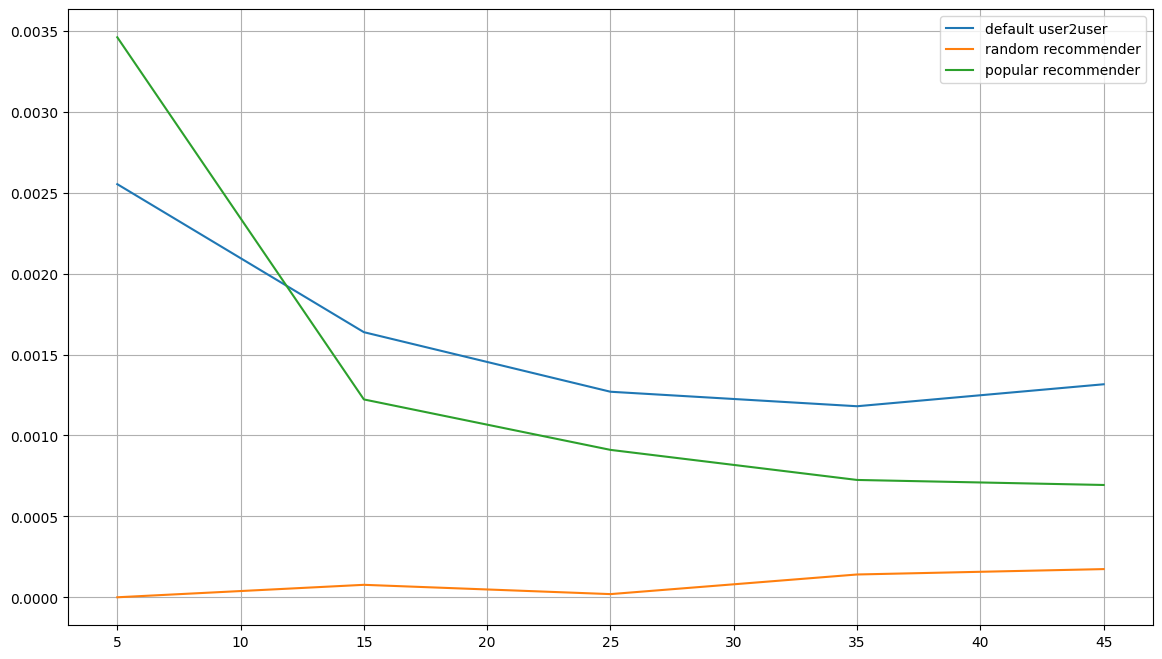

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(ks, j_u2u, label='default user2user')
plt.plot(ks, j_rnd, label='random recommender')
plt.plot(ks, j_pop, label='popular recommender')
plt.grid()
plt.legend()
plt.show()

Заметим, что при маленьких $k$ хорошо показывает себя выдача самых популярных треков, но уже с $k=15$ модель User2User показывает себя лучше всех.

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
class User2UserSparse(BaseModel):
    def __init__(self, ratings):

        super().__init__(ratings)
        self.R = scs.csr_matrix(self.R)
        self.similarity_func = jaccard
        self.alpha = 0.035

    def similarity(self, user_vector: np.array):
        return self.similarity_func(self.R, user_vector)       # мера Жаккара для разреженных матриц

    def index_sort(self, scores: np.array) -> np.array:
        # сортировка индексов треков в порядке убывания их оценок
        ans = [(scores[i], i) for i in range(len(scores))]
        ans = sorted(ans, key=lambda x: x[0])
        return np.array([i[1] for i in ans])[::-1]

    def recommend(self, uid: int):
        sim = self.similarity(self.R[uid])
        sim = np.array(np.array(sim)[0].toarray()[0])        # преобразование результата в плотный формат для дальнейших вычислений
        # фильтрация пользователей с порогом alpha
        idxes = np.array(sim) > self.alpha
        neighbors = np.array(sim)[idxes]
        weighted = self.R[idxes].T @ neighbors
        return self.index_sort(weighted / np.sum(neighbors))         # возвращаем индексы треков, отсортированных по убыванию оценок

In [ ]:
# получение рекомендаций для тестового набора данных

model = User2UserSparse(train_ratings)
rec = model.get_test_recommendations(k)

<ipython-input-115-c93daab82def>:22: RuntimeWarning: divide by zero encountered in divide
  return self.index_sort(weighted / np.sum(neighbors))
<ipython-input-115-c93daab82def>:22: RuntimeWarning: invalid value encountered in divide
  return self.index_sort(weighted / np.sum(neighbors))


In [ ]:
# замер времени выполнения для модели с обычными матрицами

start = time.perf_counter()
model = User2User(train_ratings)
_ = model.get_test_recommendations(50)
print(f'С numpy array: {(time.perf_counter() - start)}')

С numpy array: 37.493861258000834


In [ ]:
# замер времени выполнения для модели с разреженными матрицами

start = time.perf_counter()
model = User2UserSparse(train_ratings)
_ = model.get_test_recommendations(50)
print(f'С разреженной таблицей: {(time.perf_counter() - start)}')

<ipython-input-115-c93daab82def>:22: RuntimeWarning: divide by zero encountered in divide
  return self.index_sort(weighted / np.sum(neighbors))
<ipython-input-115-c93daab82def>:22: RuntimeWarning: invalid value encountered in divide
  return self.index_sort(weighted / np.sum(neighbors))


С разреженной таблицей: 12.768375802999799


Когда начала использовать разреженную таблицу, то время получения рекомендаций значительно уменьшилось (примерно в 2-3 раза)

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
user_id = np.random.randint(0, model.n_users)        # случайный выбор пользователя для проверки рекомендаций

In [ ]:
# вывод треков, которые уже были прослушаны пользователем
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
1,I'll Play The Blues For You,['Albert King']
2,Breaking Up Somebody's Home,['Albert King']
25,Run Through The Jungle,['Creedence Clearwater Revival']
35,Fresh Blood,['Eels']
56,Tonight,['Yuksek']
89,Addicted To Love,"['Robert Palmer', 'Eric ""E.T."" Thorngren']"
97,Heads Will Roll,['Yeah Yeah Yeahs']
108,I Wanna Get Funky,['Albert King']
110,Travelin' Man,['Albert King']
146,Let's Dance,['David Bowie']


In [ ]:
# получение и вывод предсказанных рекомендаций

preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-115-c93daab82def>:22: RuntimeWarning: divide by zero encountered in divide
  return self.index_sort(weighted / np.sum(neighbors))
<ipython-input-115-c93daab82def>:22: RuntimeWarning: invalid value encountered in divide
  return self.index_sort(weighted / np.sum(neighbors))


Predicted tracks:


,name,artists
67312,Послала,"['VAVAN', 'Real Girl']"
67311,Башня,"['Даня Милохин', 'Мумий Тролль']"
67310,Снегом стать,['Жин-Жин']
67309,Лифон,"['Uniqe', 'nkeeei', 'ARTEM SHILOVETS', 'SAGARA']"
67308,Син Икэн Ул,"['Зинира Рамазанова', 'Ризат Рамазанов']"
67307,I AM WOMAN,['Emmy Meli']
67306,Погоди,['DSPRITE']
67305,Мин синсез дэ яши алам димэ,"['Зинира Рамазанова', 'Ризат Рамазанов']"
67304,Чыршы-чыршы,['Илсөя Бәдретдинова']
67303,Ещё выше,['Градусы']


In [ ]:
# вывод треков, которые были прослушаны пользователем во время тестирования

test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
60070,Господь,['Gojiakanuggi']
60124,Sugaan Essena,['The Hu']
60158,"Пиво, пиво","['Korpiklaani', 'Тролль Гнёт Ель']"
60572,Das Model,['Kraftwerk']
62327,Крошка,['Монеточка']
62331,Переживу,['Монеточка']
62332,Америка,['Монеточка']


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

$$L(p_u, q_i) = (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\|p_u\|^2 + \|q_i\|^2\right)$$

$$\frac{\partial L (p_u, q_i)}{\partial p_{uk}} = 2(\hat{r}_{ui} - r_{ui}) q_{ik} + 2\lambda p_{uk} \qquad \frac{\partial L (p_u, q_i)}{\partial q_{ik}} = 2(\hat{r}_{ui} - r_{ui}) p_{uk} + 2\lambda q_{ik} $$

$$\frac{\partial L (p_u, q_i)}{p_u} = 2(\hat{r}_{ui} - r_{ui}) q_{i} + 2\lambda p_{u} \qquad \frac{\partial L (p_u, q_i)}{q_i} = 2(\hat{r}_{ui} - r_{ui}) p_{u} + 2\lambda q_{i}$$

$$ p_u^{(j+1)} = p_u^{(j)} - \eta \left(2(\hat{r}_{ui} - r_{ui}) q_{i}^{(j)} + 2\lambda p_{u}^{(j)}\right)$$

$$q_i^{(j+1)} = q_i^{(j)} - \eta \left(2(\hat{r}_{ui} - r_{ui}) p_{u}^{(j)} + 2\lambda q_{i}^{(j)}\right)$$


**ALS:**

$$L(P, Q) = \|P^T Q - R\|^2_F + \lambda \left(\|P\|_F^2 + \|Q\|_F^2\right) = \|Q^T P - R^T\|^2_F + \lambda \left(\|P\|_F^2 + \|Q\|_F^2\right)$$

Для Q:

$$L(P, q_i) = \|P^T q_i - (R)_i\|_2^2 + \lambda \left(\|P\|_F^2 + \|q_i\|_2^2\right) \\
\frac{\partial L (P, q_i)}{\partial q_{i}} = 2P(P^T q_i - (R)_i) + 2\lambda q_i = 2 \left(PP^T + \lambda I\right) q_i - 2P(R)_i$$

$$\frac{\partial L (P, q_i)}{\partial q_{i}} \qquad 2 \left(PP^T + \lambda I\right) q_i - 2P(R)_i = 0$$

$$q_i = \left(PP^T + \lambda I\right)^{-1} P(R)_i \qquad Q = \left(PP^T + \lambda I\right)^{-1} PR
$$

Для P:
$$L(p_u, Q) = \|Q^T p_u - (R^T)_u\|_2^2 + \lambda \left(\|p_u\|_2^2 + \|Q\|_F^2\right)$$

$$\frac{\partial L (p_u, Q)}{\partial p_{u}} = 2Q(Q^T p_u - (R^T)_u) + 2\lambda p_u = 2 \left(QQ^T + \lambda I\right) p_u - 2Q(R^T)_u$$

$$\frac{\partial L (p_u, Q)}{\partial p_{u}} \qquad 2 \left(QQ^T + \lambda I\right) p_u - 2Q(R^T)_u = 0$$

$$p_u = \left(QQ^T + \lambda I\right)^{-1} Q(R^T)_u \qquad P = \left(QQ^T + \lambda I\right)^{-1} QR^T$$



**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        # проверка, что режим оптимизации задали корректно
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):

        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                i_idx = np.random.choice(self.n_items)
                u_idx = np.random.choice(self.n_users)

                grad = 2 * (np.inner(self.P[u_idx], self.Q[i_idx]) - self.R[u_idx, i_idx])
                p_u_grad = grad * self.Q[i_idx] + 2 * self.lamb * self.P[u_idx]
                q_i_grad = grad * self.P[u_idx] + 2 * self.lamb * self.Q[i_idx]

                self.P[u_idx] = self.P[u_idx] - self.lr * p_u_grad
                self.Q[i_idx] = self.Q[i_idx] - self.lr * q_i_grad

            elif self.mode == 'als':
                P0 = self.Q.T @ self.Q + self.lamb * np.eye(self.dim)
                P1 = self.Q.T @ self.R.T
                self.P = (np.linalg.inv(P0) @ P1).T

                Q0 = self.P.T @ self.P + self.lamb * np.eye(self.dim)
                Q1 = self.P.T @ self.R
                self.Q = (np.linalg.inv(Q0) @ Q1).T

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T        # генерация рекомендаций для пользователя

        return np.argsort(pred_rating)[::-1]        # возвращаем индексы треков, отсортированных по убыванию предсказанных оценок

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
res = []
for hidden_dim in tqdm([150, 200, 250, 300, 350, 400, 450]):
    model = LatentFactorModel(train_ratings, dim=hidden_dim, mode='sgd')        # модель с заданной размерностью скрытого пространства и методом SGD
    model.fit(50)
    for k in [5, 10, 15, 20, 25]:
        recs = model.get_test_recommendations(k)

        res.append({
            'mapk': mapk(test_relevant, recs, k),
            'hidden_dim': hidden_dim,
            'k': k
        })

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

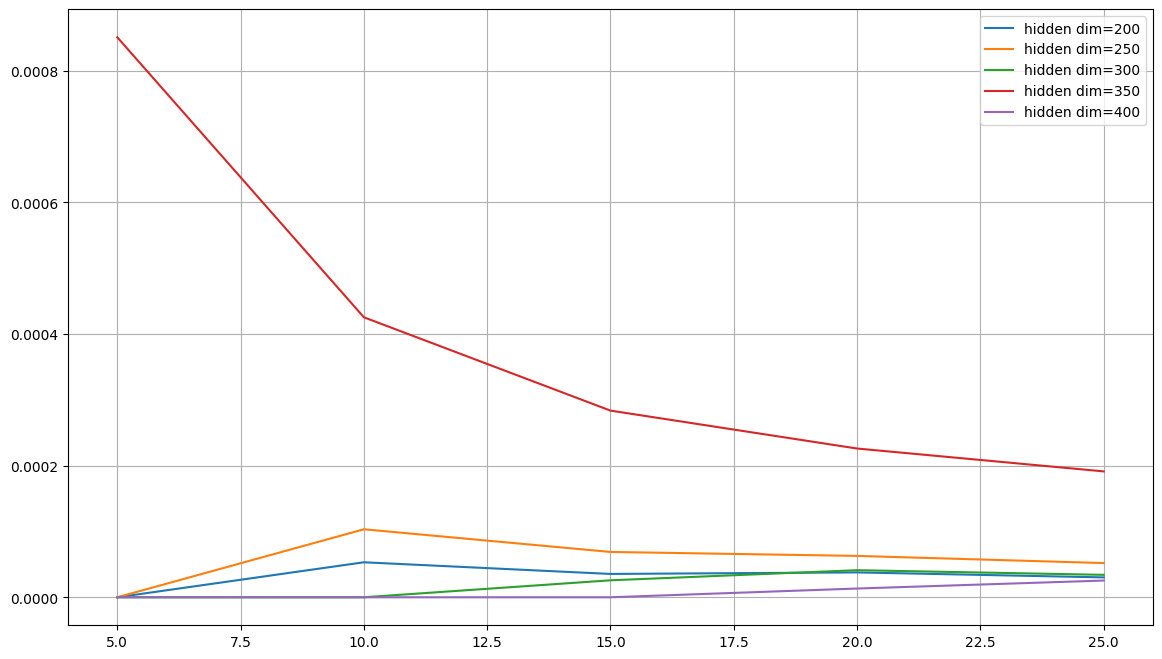

In [ ]:
plt.figure(figsize=(14, 8))
for hidden_dim in [200, 250, 300, 350, 400]:
    x = []
    y = []
    for i in res:
        if i['hidden_dim'] == hidden_dim:
            x.append(i['k'])
            y.append(i['mapk'])
    plt.plot(x, y, label=f'hidden dim={hidden_dim}')
plt.grid()
plt.legend()
plt.show()

Отлично, вот мы и получили модель, которая работает лучше, чем User2User.

In [ ]:
res = []
for hidden_dim in tqdm([25, 50, 75, 100]):
    model = LatentFactorModel(train_ratings, dim=hidden_dim, mode='als')        # модель с заданной размерностью скрытого пространства и методом ALS
    model.fit(300)
    for k in [5, 10, 15, 20, 25]:
        recs = model.get_test_recommendations(k)
        res.append({
            'mapk': mapk(test_relevant, recs, k),
            'hidden_dim': hidden_dim,
            'k': k
        })

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

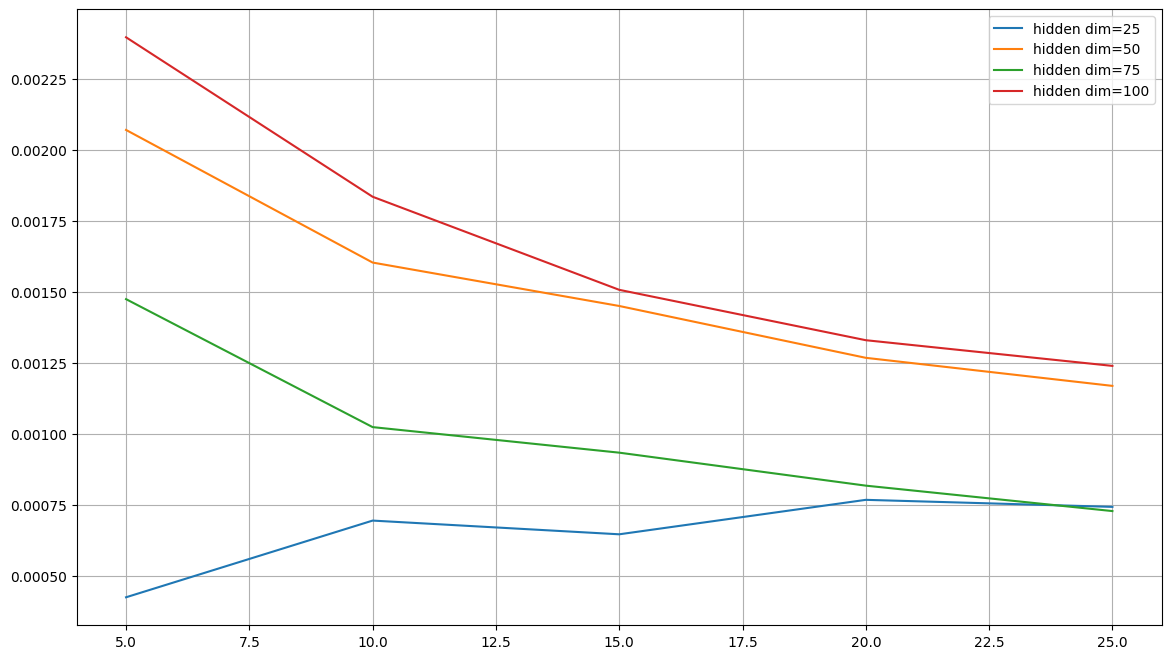

In [ ]:
plt.figure(figsize=(14, 8))
for hidden_dim in [25, 50, 75, 100]:
    x = []
    y = []
    for i in res:
        if i['hidden_dim'] == hidden_dim:
            x.append(i['k'])
            y.append(i['mapk'])
    plt.plot(x, y, label=f'hidden dim={hidden_dim}')
plt.grid()
plt.legend()
plt.show()

Подобрались гиперпараметры так, что теперь и при ALS, и при SGD для латентной модели, ее $MAP@k$ выше, чем у User2User.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степень обученности модели вручную.

In [ ]:
# возьмем ALS со скрытой размерностью 100 и 300 эпохами

model = LatentFactorModel(train_ratings, dim=100, mode='als')
model.fit(300)

example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id        # получение идентификатора трека для трека 'Выхода нет'

# вычисление похожих треков в латентном пространстве
preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.696271
2179,Восьмиклассница,['КИНО'],0.630644
16295,Push the Sky Away,['Nick Cave & The Bad Seeds'],0.604272
17794,Несуразная,['АлоэВера'],0.604272
17795,Георгины,['АлоэВера'],0.604272
27732,Я верю,['Ляпис Трубецкой'],0.604272
9876,Wake Up,['Cheese People'],0.604272
16786,Previous Crimes,['Devastations'],0.604272
5287,Home,['Edward Sharpe and the Magnetic Zeros'],0.604272


Ну, уже и не такие плохие рекомендации вышли

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [ ]:
model_u2u = User2User(train_ratings)        # создание модели User2User на основе обучающих данных

model_lfm = LatentFactorModel(train_ratings, dim=100, mode='als')
model_lfm.fit(300)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# топ-100
rec_u2u = model_u2u.get_test_recommendations(100)
rec_lfm = model_lfm.get_test_recommendations(100)

In [ ]:
rec_u2u

array([[10798,  9693,  6441, ...,  7401,  7286,  7284],
       [ 2814, 24500,   805, ..., 13029,  4551, 38671],
       [ 1073,  2555,  1019, ...,  7767, 29050, 35064],
       ...,
       [18666,  7533, 48893, ..., 35293, 34298, 24924],
       [ 4032,   805,  9694, ..., 20620, 10996,  4463],
       [47222, 26580, 22371, ..., 50211, 50173, 50043]])

In [ ]:
rec_lfm

array([[ 9693,  4507,   189, ..., 15376, 12996,  3189],
       [18914, 27891, 29169, ...,  2826,  3013, 38227],
       [ 1019, 11493,  2555, ..., 24141,  9433,  5213],
       ...,
       [ 1019, 15242, 40209, ..., 11675, 10576, 46279],
       [ 3822,  9694,  7780, ...,   746, 34046,  4074],
       [39045, 28529,  5057, ..., 56746, 56756, 40293]])

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [ ]:
data_user = []
data_item = []

# добавление рекомендаций User2User
for i in range(rec_u2u.shape[0]):
    for j in rec_u2u[0]:
        data_user.append(int(i))
        data_item.append(int(j))

# аналогично LatentFactorModel
for i in range(rec_lfm.shape[0]):
    for j in rec_lfm[0]:
        data_user.append(int(i))
        data_item.append(int(j))

# DataFrame с уникальными парами (user, item)
df = pd.DataFrame(data={'user': data_user, 'item': data_item})
df = df.drop_duplicates(subset=['user', 'item'])

In [ ]:
# вычисление косинусного расстояния между эмбеддингами LFM пользователя и трека

cos_dist = model_lfm.P @ model_lfm.Q.T
data_cos_dist = []
for i in range(df.shape[0]):
    data_cos_dist.append(cos_dist[df.iloc[i]['user']][df.iloc[i]['item']])
df['cos_dist'] = data_cos_dist

In [ ]:
# вычисление среднего значения меры Жаккара между пользователем и остальными пользователями

user_prep = []

for i in range(model_u2u.R.shape[0]):
    user_prep.append(np.mean(jaccard(model_u2u.R, model_u2u.R[i])) - 1 / model_u2u.R.shape[0])
data_jac = []

for i in range(df.shape[0]):
    data_jac.append(user_prep[int(df.iloc[i]['user'])])
    
df['jac'] = data_jac

In [ ]:
# вычислим доли пользователей, слушавших каждый трек

track_prep = np.array(train_ratings.groupby('trackId').count()).T[0] / 243
data_part_listened = []
for i in range(df.shape[0]):
    data_part_listened.append(track_prep[int(df.iloc[i]['item'])])
df['part_listened'] = data_part_listened

In [ ]:
# вычислим количества треков, прослушанных пользователем

user_prep = np.array(train_ratings.groupby('userId').count()).T[0]
data_user_listened = []

for i in range(df.shape[0]):
    data_user_listened.append(user_prep[int(df.iloc[i]['user'])])
    
df['user_listened'] = data_user_listened

In [ ]:
df

,user,item,cos_dist,jac,part_listened,user_listened
0,0,10798,0.114750,0.003435,0.086420,206
1,0,9693,0.144612,0.003435,0.123457,206
2,0,6441,0.096694,0.003435,0.012346,206
3,0,4507,0.142339,0.003435,0.037037,206
4,0,724,0.115407,0.003435,0.028807,206
...,...,...,...,...,...,...
46995,234,7718,0.055621,0.006258,0.008230,231
46996,234,14043,0.055621,0.006258,0.008230,231
46997,234,15376,0.055621,0.006258,0.008230,231
46998,234,12996,0.038859,0.006258,0.020576,231


In [ ]:
model_u2u.R.shape

(241, 67313)

In [ ]:
train_ratings

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404
...,...,...
129399,240,65424
129400,240,65436
129401,240,65480
129402,240,65515


In [ ]:
# спискок последних 50 прослушанных треков для каждого пользователя

listened_list = [[] for i in range(model_u2u.R.shape[0])]
for i in range(train_ratings.shape[0]):
    listened_list[int(train_ratings.iloc[i]['userId'])].append(int(train_ratings.iloc[i]['trackId']))

In [ ]:
for i in range(len(listened_list)):
    listened_list[i] = listened_list[i][-50:]

In [ ]:
# создадим целевую переменую: попал ли трек в последние 50 прослушанных треков пользователем

Y = []

for i in range(df.shape[0]):
    Y.append(int(df.iloc[i]['item']) in listened_list[int(df.iloc[i]['user'])])
    
Y = np.array(Y)

In [ ]:
Y.mean()

0.0018789720917380493

In [ ]:
# разделение данных на обучающую и тестовую выборки с сохранением пропорций целевой переменной

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, Y, random_state=42, test_size=0.4, stratify=Y)

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
import catboost

train_pool = catboost.Pool(X_train, y_train)
test_pool = catboost.Pool(X_test, y_test)

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.